
**Introduction**

Githublink: https://github.com/donxiya/Wine-Rating-Price

For this project, we used a dataset originally scraped from Vivino.com, a leading online wine review and recommendation platform. The dataset was made publicly available on Kaggle by user Andrii Budnyak.

Budnyak, A. (2022). Wine rating and price. Kaggle. https://www.kaggle.com/datasets/budnyak/wine-rating-and-price

The dataset includes four CSV files, each representing a different wine style: red, white, rosé, and sparkling. Each file shares a consistent schema with the following key attributes:

Name: Name of the wine

Country: Country of origin

Region: Specific region or province of origin

Winery: Name of the producing winery

Rating: Average user rating

NumberOfRatings: Count of user reviews (minimum of 25 to ensure reliability)

Price: Listed price in Euros

Year: Year of production

According to the data author, wines with fewer than 25 user ratings were excluded to preserve statistical validity, as Vivino appears to omit these from public view for reliability reasons.





**Project Goal**

The primary goal of this project is to build an intelligent wine recommendation system that assists consumers in discovering wines aligned with their taste preferences. Whether a user provides a favorite wine or simply specifies filters like price range, rating, and wine type, the system utilizes unsupervised machine learning techniques to identify wines that are similar in character and appeal.

To this end, we employed K-Means Clustering and Gaussian Mixture Models (GMM) to group wines based on features such as price, rating, and production year. This approach enables a user-friendly, data-driven wine discovery experience.



**Identify an Unsupervised Learning Problem**

This project aims to help consumers find wines similar to ones they like by applying unsupervised learning. Since the dataset lacks labeled categories, we use clustering methods to group wines based on features like price, rating, and year.

We explored three main algorithms:

**K-Means Clustering:** Quickly groups wines into clusters by minimizing distance to cluster centers. It’s simple but assumes equal-sized, spherical clusters.

**Hierarchical Clustering:** Builds a tree of clusters without needing to predefine the number. It helps visualize how wines group together at different levels of similarity.

**Gaussian Mixture Model (GMM):** A flexible model that assigns probabilities to clusters, allowing for overlapping and elliptical groupings. It captures more subtle patterns than K-Means.

These methods let us segment wines and support a recommendation system based on feature similarity.



In [1]:

# imports
# Data Handling & Manipulation
import pandas as pd
import numpy as np
from pandas import read_csv, DataFrame, Series

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree  # For plotting decision trees

# Preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Model Selection & Evaluation
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, silhouette_score

# Machine Learning Models
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture

# Similarity & Distance Metrics
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import dendrogram, linkage

# Widgets & Interactive Tools (Jupyter-specific)
import ipywidgets as widgets
from IPython.display import display, clear_output

# Warnings
import warnings
warnings.filterwarnings('ignore')




**Dataset Overview**

We used the Wine Rating and Price dataset from Kaggle, which includes the following features:

Name: The name of the wine

Country: Country of origin

Region: Sub-national origin (e.g., province or region)

Winery: Producer of the wine

Rating: Average user rating (0–5 scale)

NumberOfRatings: Total number of user ratings

Price: Wine price in Euros

Year: Vintage year

In [2]:



# Load each CSV into a DataFrame
df_red = pd.read_csv('../input/wine-rating-and-price/Red.csv')
df_white = pd.read_csv('../input/wine-rating-and-price/White.csv')
df_sparkling = pd.read_csv('../input/wine-rating-and-price/Sparkling.csv')
df_rose = pd.read_csv('../input/wine-rating-and-price/Rose.csv')  # example names

# Add a new column 'wine_type' to each DataFrame
df_red['Type'] = 'red'
df_white['Type'] = 'white'
df_sparkling['Type'] = 'sparkling'
df_rose['Type'] = 'rose'  # or whatever label you prefer

# Concatenate all DataFrames into one
df_wine = pd.concat([df_red, df_white, df_sparkling, df_rose], ignore_index=True)

# Check combined DataFrame info
print(df_wine.info())
print(df_wine['Type'].value_counts())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13834 entries, 0 to 13833
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             13834 non-null  object 
 1   Country          13834 non-null  object 
 2   Region           13834 non-null  object 
 3   Winery           13834 non-null  object 
 4   Rating           13834 non-null  float64
 5   NumberOfRatings  13834 non-null  int64  
 6   Price            13834 non-null  float64
 7   Year             13834 non-null  object 
 8   Type             13834 non-null  object 
dtypes: float64(2), int64(1), object(6)
memory usage: 972.8+ KB
None
Type
red          8666
white        3764
sparkling    1007
rose          397
Name: count, dtype: int64


In [3]:


# EDA: Data Cleaning

# 'N.V.' wines are nonvintage blends from multiple years.
# We'll create a separate indicator column for these,
# and fill in the year with the column median to ensure compatibility with ML models.

# Replace 'N.V.' with NaN
df_wine['Year'] = df_wine['Year'].replace('N.V.', np.nan)

# Add indicator column: 1 if nonvintage, 0 otherwise
df_wine['isNonvintage'] = df_wine['Year'].isna().astype(int)

# Convert Year to float (to handle NaNs)
df_wine['Year'] = df_wine['Year'].astype(float)

# Compute median year (ignoring NaNs)
median_year = df_wine['Year'].median()

# Fill NaNs with the median year
df_wine['Year'] = df_wine['Year'].fillna(median_year)


In [4]:


#EDA: check for null and duplicate
df_wine.isnull().sum().sort_values(ascending=False)

df_wine.duplicated().sum()
df_wine =df_wine.drop_duplicates()

#Standarize text:
df_wine['Country'] = df_wine['Country'].str.strip().str.title()
df_wine['Winery'] = df_wine['Winery'].str.strip()
df_wine['Region'] = df_wine['Region'].str.strip().str.title()



In [5]:

#Parse or Encode Categorical Columns
top_countries = df_wine['Country'].value_counts().nlargest(10).index
df_wine['Country'] = df_wine['Country'].apply(lambda x: x if x in top_countries else 'Other')

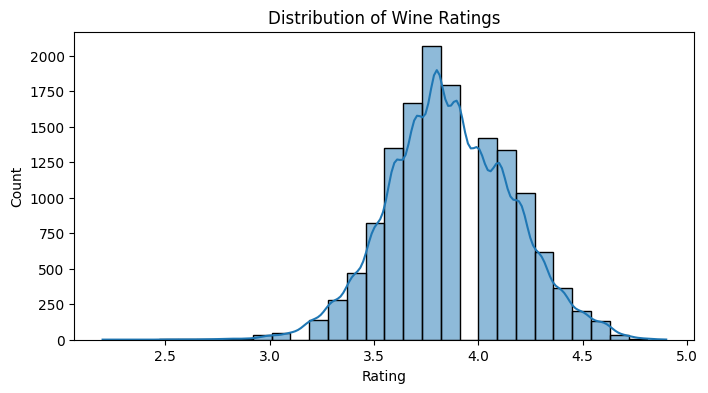

Min Rating: 2.2
Ratings with value 0:
 Empty DataFrame
Columns: [Name, Country, Region, Winery, Rating, NumberOfRatings, Price, Year, Type, isNonvintage]
Index: []


In [6]:


# Histogram of Ratings
plt.figure(figsize=(8, 4))
sns.histplot(df_wine['Rating'], bins=30, kde=True)
plt.title('Distribution of Wine Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

# Check for invalid values
print("Min Rating:", df_wine['Rating'].min())
print("Ratings with value 0:\n", df_wine[df_wine['Rating'] == 0])

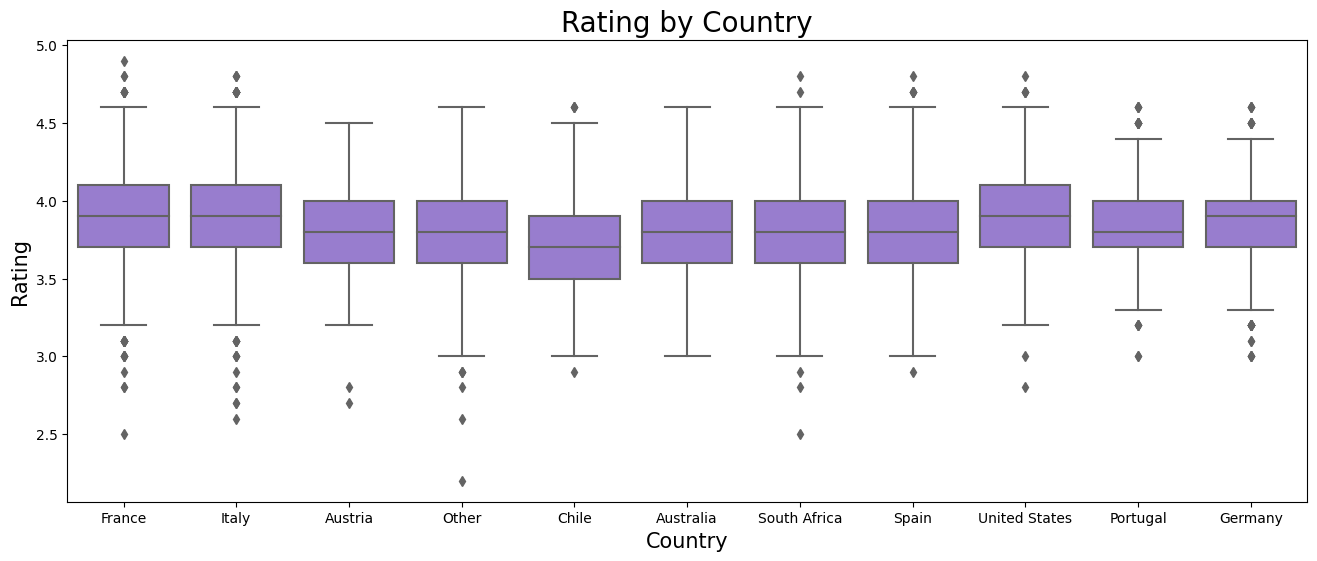

In [7]:

#rating by country
LEV_countries = df_wine.Country.value_counts()[:12] #Countries with the largest export volume

plt.figure(figsize=(16,6))

graph = sns.boxplot(x='Country', y='Rating',
                 data=df_wine[df_wine.Country.isin(LEV_countries.index.values)],
                 color='mediumpurple')
graph.set_title("Rating by Country", fontsize=20)
graph.set_xlabel("Country", fontsize=15)
graph.set_ylabel("Rating", fontsize=15)
graph.set_xticklabels(graph.get_xticklabels())

plt.show()

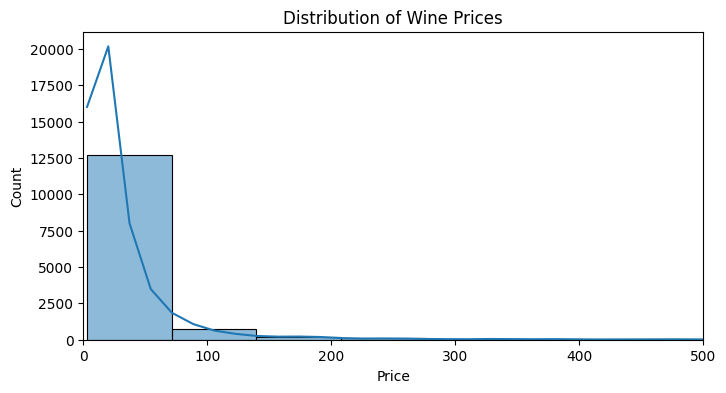

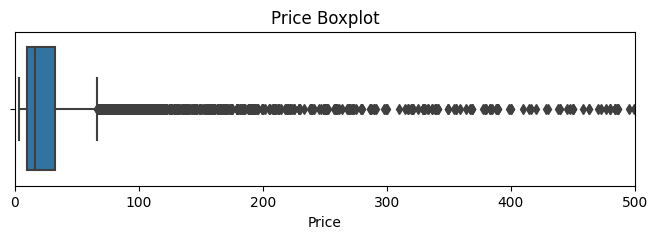

                                                   Name Country  \
2344                                       Pomerol 2012  France   
7466  Saint-Émilion Grand Cru (Premier Grand Cru Cla...  France   
5560           Pauillac (Premier Grand Cru Classé) 2010  France   
4395           Pauillac (Premier Grand Cru Classé) 1992  France   
4124     Pessac-Léognan (Premier Grand Cru Classé) 2010  France   

                       Region                     Winery  Rating  \
2344                  Pomerol                     Pétrus     4.7   
7466  Saint-Émilion Grand Cru             Château Ausone     4.5   
5560                 Pauillac  Château Lafite Rothschild     4.4   
4395                 Pauillac  Château Lafite Rothschild     4.5   
4124           Pessac-Léognan         Château Haut-Brion     4.6   

      NumberOfRatings    Price    Year Type  isNonvintage  
2344              204  3410.79  2012.0  red             0  
7466               72  1599.95  2010.0  red             0  
5560    

In [8]:

# Histogram of Price
plt.figure(figsize=(8, 4))
sns.histplot(df_wine['Price'], bins=50, kde=True)
plt.title('Distribution of Wine Prices')
plt.xlabel('Price')
plt.ylabel('Count')
plt.xlim(0, 500)  # adjust as needed to zoom in
plt.show()

# Boxplot to visualize outliers
plt.figure(figsize=(8, 2))
sns.boxplot(x=df_wine['Price'])
plt.title('Price Boxplot')
plt.xlim(0, 500)  # adjust if necessary
plt.show()

# Show potential extreme outliers
print(df_wine[df_wine['Price'] > 1000].sort_values(by='Price', ascending=False).head())

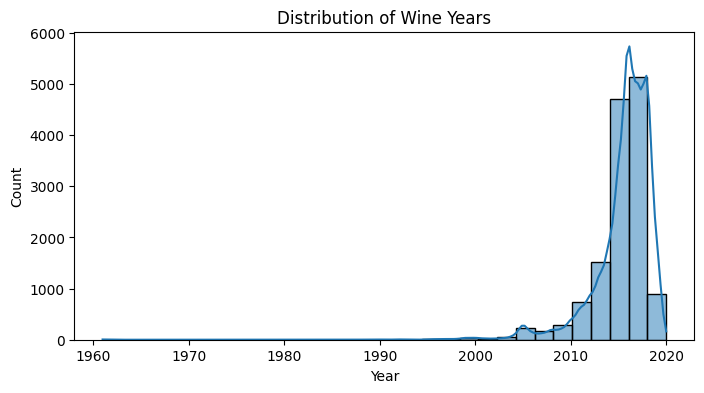

Min Year: 1961.0
Max Year: 2020.0


,Name,Country,Region,Winery,Rating,NumberOfRatings,Price,Year,Type,isNonvintage


In [9]:


# Histogram of Year
plt.figure(figsize=(8, 4))
sns.histplot(df_wine['Year'], bins=30, kde=True)
plt.title('Distribution of Wine Years')
plt.xlabel('Year')
plt.ylabel('Count')
plt.show()

# Check for strange year values
print("Min Year:", df_wine['Year'].min())
print("Max Year:", df_wine['Year'].max())

# Show years that are suspiciously old or futuristic
df_wine[(df_wine['Year'] < 1900) | (df_wine['Year'] > 2025)]

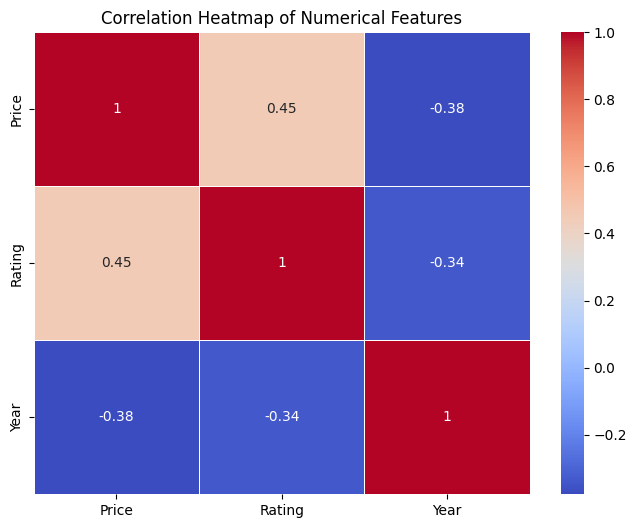

In [10]:


# Correlation heat map
# Select only numerical features
numeric_cols = ['Price', 'Rating', 'Year']
corr_matrix = df_wine[numeric_cols].corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Heatmap of Numerical Features")
plt.show()

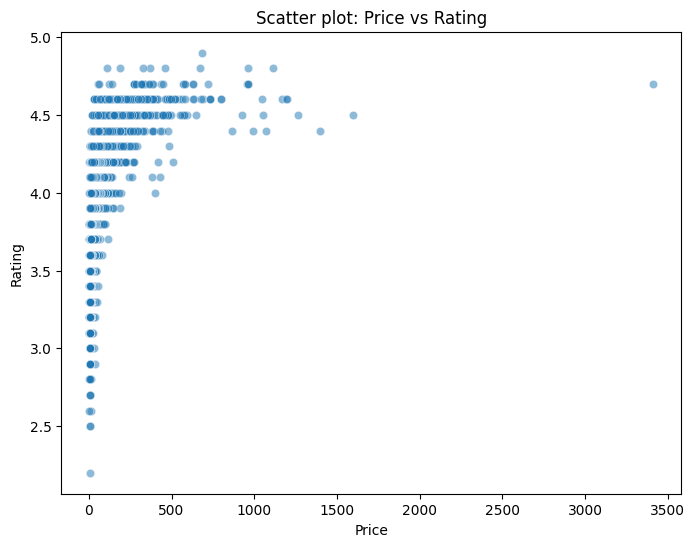

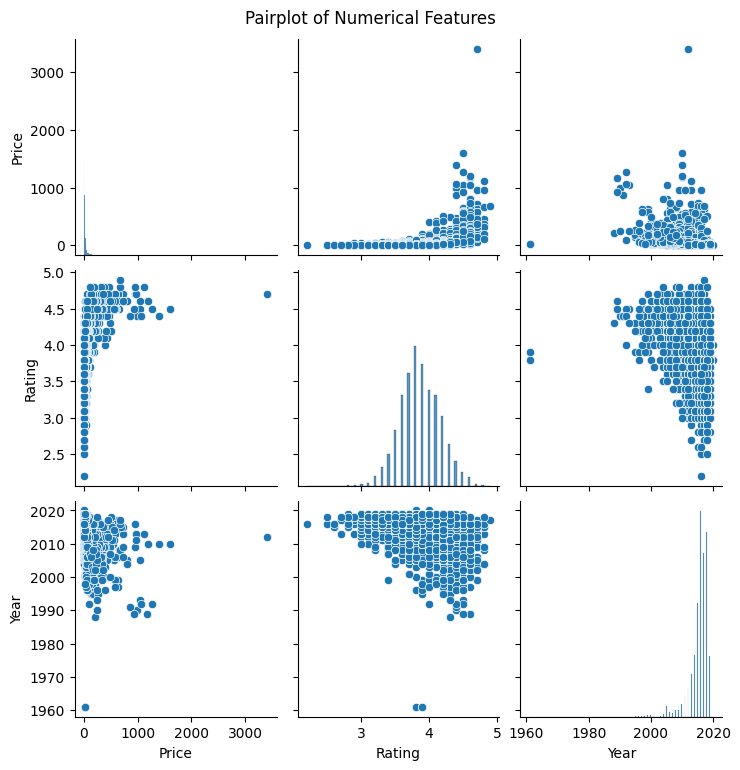

In [11]:


# Scatter plot: Price vs Rating
plt.figure(figsize=(8,6))
sns.scatterplot(data=df_wine, x='Price', y='Rating', alpha=0.5)
plt.title('Scatter plot: Price vs Rating')
plt.show()


# Pairplot for selected numerical features
sns.pairplot(df_wine[['Price', 'Rating', 'Year']])
plt.suptitle('Pairplot of Numerical Features', y=1.02)
plt.show()



Correlation Analysis

The analysis of the dataset shows that Price and Rating have a positive correlation, indicating that higher-rated wines tend to be more expensive on average. However, this relationship is moderate, suggesting that price alone is not a perfect predictor of quality.

On the other hand, Region of Origin does not show a clear correlation with either price or rating. This suggests that the geographic region may not strongly influence the wine’s cost or perceived quality within this dataset, possibly due to the diversity of wine styles and producers across regions.

In [12]:


#Standardize Numerical Columns
# 1. One-hot encode 'Region'
df_wine_encoded = pd.get_dummies(df_wine, columns=['Region'])

# 2. Log-transform Price (add small constant to avoid log(0))
df_wine_encoded['Log_Price'] = np.log(df_wine_encoded['Price'] + 1e-6)

# 3. Define features: log-transformed price + rating + one-hot encoded regions
features_to_scale = ['Log_Price', 'Rating']
region_cols = [col for col in df_wine_encoded.columns if col.startswith('Region_')]
all_features = features_to_scale + region_cols

# 4. Scale the selected features
scaler = StandardScaler()
scaled_values = scaler.fit_transform(df_wine_encoded[all_features])

# 5. Create new scaled DataFrame
df_wine_scaled = df_wine_encoded.copy()
df_wine_scaled[all_features] = scaled_values



**Data Transformation and Preparation**

The dataset undergoes preprocessing to prepare it for machine learning clustering methods such as KMeans. Specifically, the categorical feature ‘Region’ is transformed via one-hot encoding, converting each unique region into a binary feature. This allows numerical algorithms to effectively process the originally non-numeric data.

Next, the Price feature is log-transformed to reduce its skewness and bring its distribution closer to normality, which improves the performance of distance-based algorithms. Alongside the log-transformed Price, the numerical features Year and Rating, together with the one-hot encoded Region columns, are combined into a single feature set.

Since clustering algorithms like KMeans are sensitive to the scale of features, all numerical features and region indicators are standardized using StandardScaler. This scaling normalizes the data to have zero mean and unit variance, preventing features with larger numeric ranges from disproportionately influencing clustering outcomes.

Finally, these scaled feature values replace the original ones in a copy of the dataset, resulting in a scaled DataFrame ready for model training and clustering analysis.


**Principal Component Analysis (PCA)** is a dimensionality reduction technique that transforms a dataset with many features into a smaller set of uncorrelated variables called principal components, while preserving as much variance as possible.

**Strengths of PCA:**

Reduces complexity: Helps simplify models and visualizations by reducing high-dimensional data to 2 or 3 dimensions.

Removes redundancy: Combines correlated features, helping eliminate multicollinearity.

Speeds up algorithms: Reduces computational cost for downstream ML tasks.

**Limitations of PCA:**

Loss of interpretability: Principal components are linear combinations of original features, making results harder to interpret.

Assumes linear relationships: PCA only captures linear patterns; it may miss meaningful nonlinear structure.

Sensitive to scaling: Features must be standardized; otherwise, PCA will be biased toward variables with larger scales.

Explained variance ratio: [0.86840917 0.13159083]


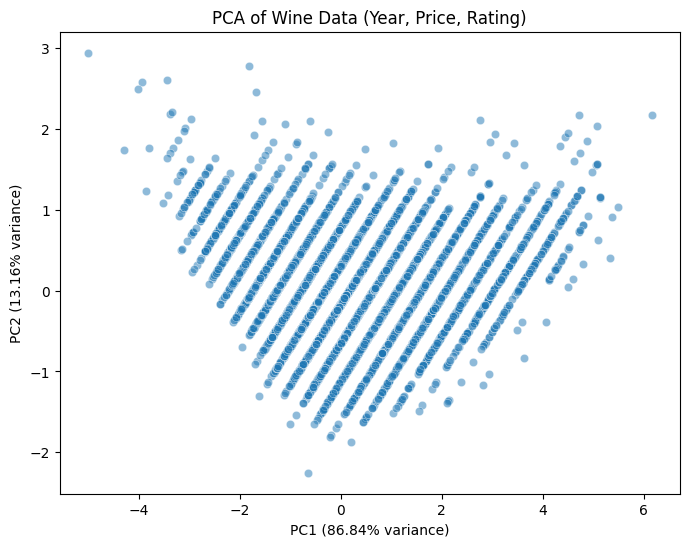

In [13]:


# Select scaled numerical features
X = df_wine_scaled[features_to_scale]

# Initialize PCA (2 components for 2D visualization)
pca = PCA(n_components=2)

# Fit and transform
X_pca = pca.fit_transform(X)

# Explained variance ratio (how much info each PC holds)
print("Explained variance ratio:", pca.explained_variance_ratio_)

# Add PCA components back to DataFrame for plotting
df_wine_scaled['PC1'] = X_pca[:, 0]
df_wine_scaled['PC2'] = X_pca[:, 1]

# Scatterplot of the first two PCs
plt.figure(figsize=(8,6))
sns.scatterplot(data=df_wine_scaled, x='PC1', y='PC2', alpha=0.5)
plt.title('PCA of Wine Data (Year, Price, Rating)')
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)")
plt.show()

In [14]:


# Components shape: (n_components, n_features)
components = pca.components_

# Put it in a DataFrame for readability
df_pca_components = pd.DataFrame(
    components, 
    columns=features_to_scale, 
    index=['PC1', 'PC2']
)

print(df_pca_components)

     Log_Price    Rating
PC1   0.707107  0.707107
PC2   0.707107 -0.707107



**By Wine Type**
As we can see below, there is no significant grouping when wine type is shown.

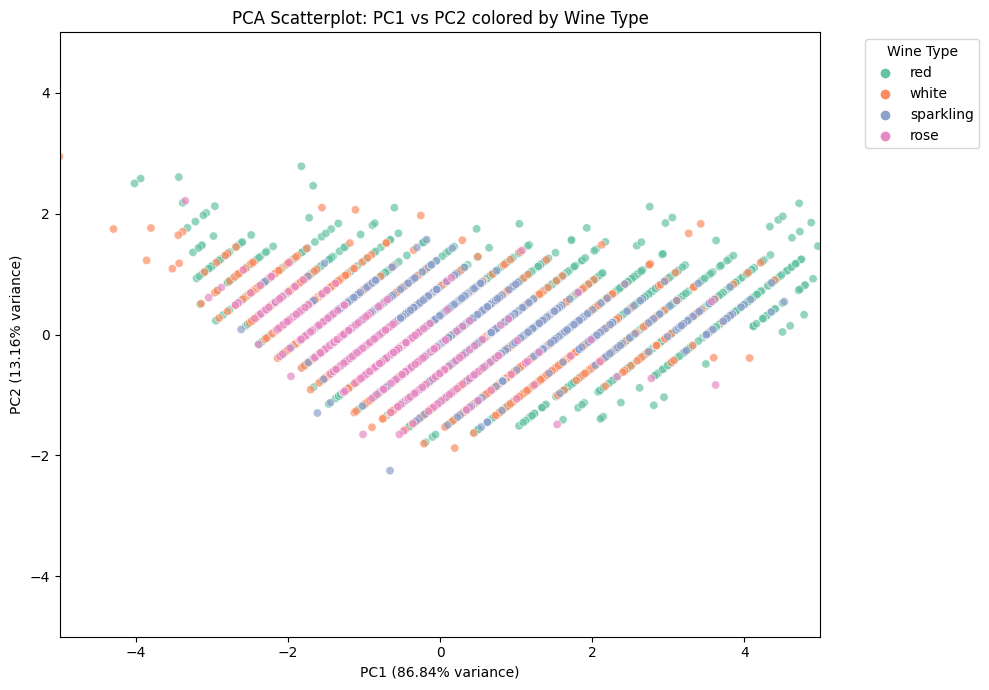

In [15]:

#PC1 vs PC2 colored by Wine Type'
plt.figure(figsize=(10, 7))

# Create a scatterplot of the two principal components (PC1 and PC2)
# Color points by wine 'Type' (e.g., red, white, etc.)
sns.scatterplot(
    data=df_wine_scaled,       # PCA-transformed and scaled dataset
    x='PC1',                   # First principal component
    y='PC2',                   # Second principal component
    hue='Type',                # Wine type used for color grouping
    palette='Set2',            # A pleasant color palette
    alpha=0.7                  # Slight transparency for overlapping points
)

plt.title('PCA Scatterplot: PC1 vs PC2 colored by Wine Type')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')

plt.xlim(-5, 5)
plt.ylim(-5, 5)

plt.legend(title='Wine Type', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()

plt.show()


**PCS Summary**

PC1 explains ~59.3% of the total variance.

PC2 explains ~22.6% of the variance.

Combined, PC1 + PC2 explain ~81.9% of the variance in the dataset.

**Principal Component 1 (PC1)**

Price (0.60) and Rating (0.58) have strong positive contributions.

Year (-0.54) contributes negatively.

**Summary:**
PC1 is primarily capturing a contrast between newer wines (lower years) and wines with higher prices and better ratings.
→ This could represent a general “quality or premium score” component — i.e., more recent high-priced, high-rated wines.

**Principal Component 2 (PC2)**

Dominated by Year (-0.82), followed by Rating (-0.51).

Price has a small negative impact.

**Summary:**
PC2 seems to separate wines based strongly on age, with older wines (high year values) scoring lower. It may also reflect some quality signal (rating), but it’s less price-influenced.





**Why K-Means Works Well for This Project**

The wine dataset is numerical and structured, which suits the distance-based nature of K-Means.

After scaling and optional dimensionality reduction (e.g., PCA), K-Means effectively groups similar wines based on price, rating, and year.

Clusters can represent taste profiles or value groups, helping users find wines that are similar to ones they already enjoy.

The centroids can serve as reference wines for each group, aiding in clear recommendations.

**Limitations of K-Means**

Requires specifying k in advance: w must choose the number of clusters before running the algorithm, which may require trial-and-error.

We will address this later using Silhouette Scores. 

Assumes spherical clusters: It may perform poorly if clusters have irregular shapes or different densities.

Sensitive to outliers: Outliers can skew centroids and affect cluster quality.

Explained variance ratios: [0.00273053 0.00116433]


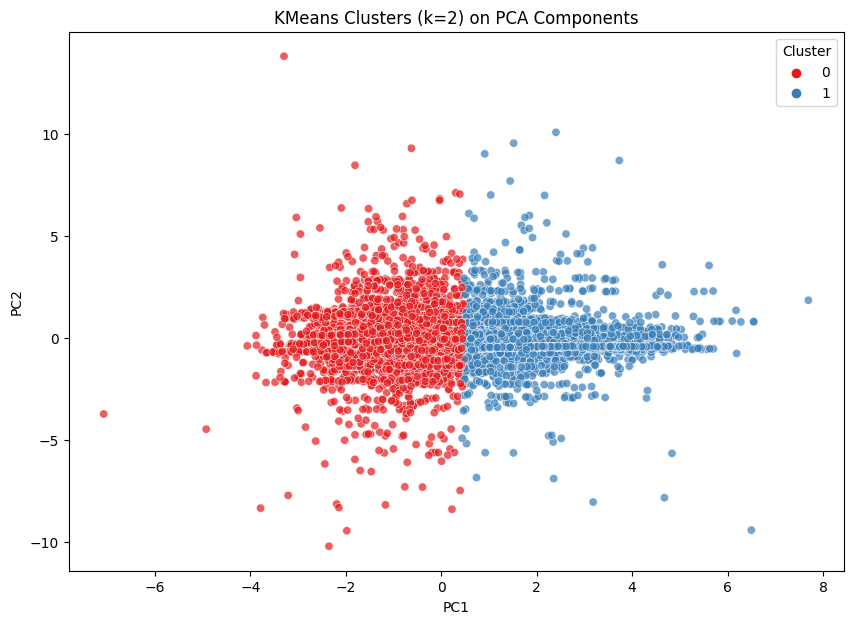

In [16]:

#K-Mean Clustering
# 1. Run PCA to reduce dimensionality to 2 components for visualization
pca = PCA(n_components=2)
pcs = pca.fit_transform(df_wine_scaled[all_features])

df_wine_scaled['PC1'] = pcs[:, 0]
df_wine_scaled['PC2'] = pcs[:, 1]

print("Explained variance ratios:", pca.explained_variance_ratio_)

# 2. Run KMeans clustering (k=2 for example)
k = 2
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
df_wine_scaled['Cluster'] = kmeans.fit_predict(df_wine_scaled[['PC1', 'PC2']])

# 3. Plot the clusters on the PCA components
plt.figure(figsize=(10,7))
sns.scatterplot(
    data=df_wine_scaled,
    x='PC1',
    y='PC2',
    hue='Cluster',
    palette='Set1',
    alpha=0.7
)
plt.title('KMeans Clusters (k=2) on PCA Components')
plt.show()




After applying K-Means clustering (with k=2) on the standardized wine dataset using features such as Year, Price, Rating, and one-hot encoded Region, we analyzed the cluster centroids:

**Cluster 0 represents wines with:**

Slightly newer years

Lower price

Lower average rating

**Cluster 1 includes wines that are:**

Older

More expensive

Higher rated

This clustering aligns well with the intuition that higher-rated wines tend to be older and more costly.

**Impact of Region Features**

While we included 860+ one-hot encoded Region columns, their contribution to the clustering result appears minimal. Most of their standardized mean values across clusters hover very close to zero, indicating:

Regions do not strongly differentiate between wine clusters.

These categorical features have low variance influence after standardization, likely due to their high dimensionality and sparsity.

Thus it will be removed from consideration.

**Conclusion**

The numerical features—Year, Price, and Rating—are the primary drivers of clustering.

Regional data, though included, does not significantly contribute to cluster separation and might be excluded or reduced (e.g., via PCA or feature selection) in future iterations for simplicity and performance.


**Silhouette Score**

The silhouette score measures how well each data point fits within its cluster compared to other clusters. It ranges from -1 to 1, where:

1 = well-clustered

0 = on the boundary

< 0 = likely misclassified

To choose the best k (number of clusters), we compute the silhouette score for various k values and pick the one with the highest score, indicating the most distinct and well-separated clustering.

As we can see below, k = 2 is out optimal choice.

Silhouette Scores by number of clusters:
  k = 2: 0.4943
  k = 3: 0.3950
  k = 4: 0.3710
  k = 5: 0.3439
  k = 6: 0.3563
  k = 7: 0.3415
  k = 8: 0.3462
  k = 9: 0.3452


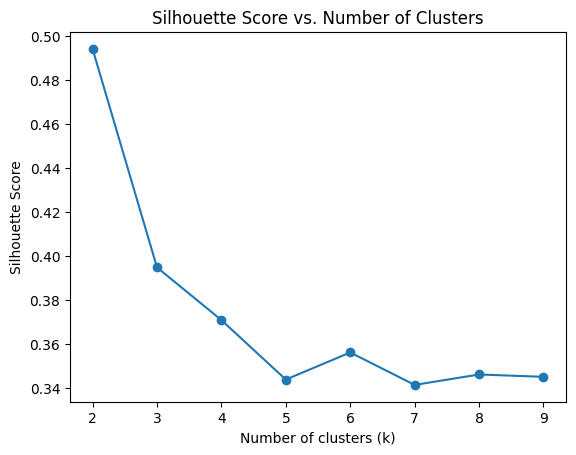

In [17]:


sil_scores = []
k_values = range(2, 10)

for k in k_values:
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(X_pca)
    sil_scores.append(silhouette_score(X_pca, labels))

print("Silhouette Scores by number of clusters:")
for k, score in zip(k_values, sil_scores):
    print(f"  k = {k}: {score:.4f}")
    
plt.plot(k_values, sil_scores, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. Number of Clusters')
plt.show()



**Hierarchical Clustering** 

Hierarchical Clustering is an unsupervised learning method that builds a tree-like structure (dendrogram) to represent nested groupings of data. It does not require pre-selecting the number of clusters, which is useful for exploring natural groupings in our wine dataset.

**Why it suits the project:**

It reveals the underlying structure among wines, showing how similar wines merge into clusters at different levels.

Good for small to medium-sized datasets with meaningful distance measures (e.g., rating and price similarity).

**Limitations:**

Scalability: Computationally expensive for large datasets.

Rigid structure: Once a merge is made, it cannot be undone (no reassignments like in K-Means)

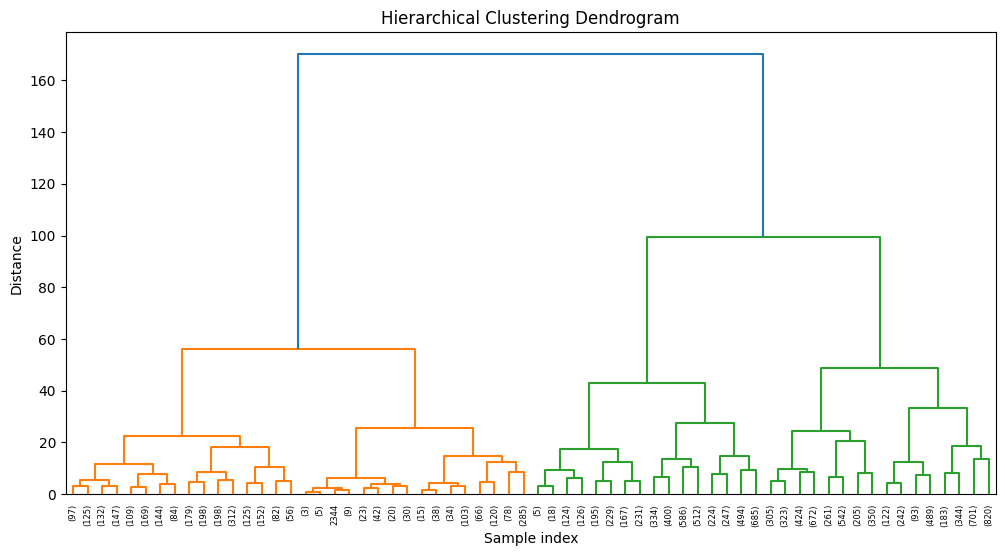

In [18]:


#Hierarchical clustering

agg_clust = AgglomerativeClustering(n_clusters=3, linkage='ward')  # or other linkage: 'complete', 'average'
labels = agg_clust.fit_predict(X_pca)  # use your PCA components or scaled data

df_wine_scaled['Cluster_Hier'] = labels

Z = linkage(X_pca, method='ward')


plt.figure(figsize=(12, 6))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample index')
plt.ylabel('Distance')
dendrogram(Z, truncate_mode='level', p=5)  # show only last 20 merges for clarity
plt.show()

In [19]:


agg_clust = AgglomerativeClustering(n_clusters=2, linkage='ward')
cluster_labels = agg_clust.fit_predict(X_pca)

df_wine_scaled['Cluster_Hier'] = cluster_labels

In [20]:


# Add cluster labels to your DataFrame
df_wine_scaled['Cluster'] = cluster_labels

# Count of wine types in each cluster
print("Count of Wine Types per Cluster:")
print(df_wine_scaled.groupby(['Cluster', 'Type']).size())

# Average numerical features by cluster
print("\nAverage Price, Rating, Year per Cluster:")
print(df_wine_scaled.groupby('Cluster')[['Price', 'Rating', 'Year']].mean())



Count of Wine Types per Cluster:
Cluster  Type     
0        red          6215
         rose          384
         sparkling     745
         white        3309
1        red          2451
         rose           13
         sparkling     262
         white         455
dtype: int64

Average Price, Rating, Year per Cluster:
             Price    Rating         Year
Cluster                                  
0        15.090605 -0.360583  2016.299916
1        93.085684  1.207575  2013.068846


Silhouette Scores by number of clusters:
  k = 2: 0.4951
  k = 3: 0.3813
  k = 4: 0.3541
  k = 5: 0.3058
  k = 6: 0.3054
  k = 7: 0.3077
  k = 8: 0.3019
  k = 9: 0.2980
  k = 10: 0.3031


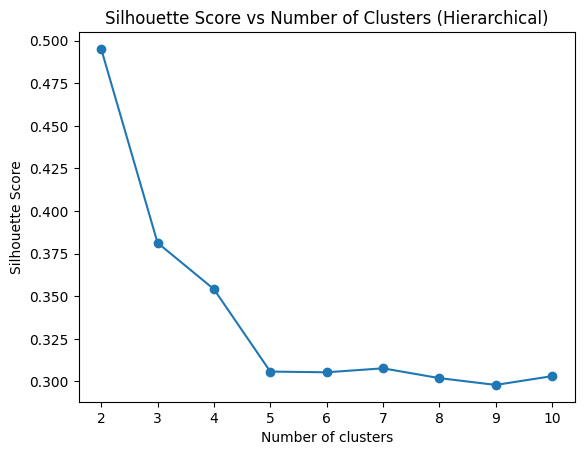

In [21]:
#we use sil_scores to determine the optimal k value

sil_scores = []
k_values = range(2, 11)

for k in k_values:
    model = AgglomerativeClustering(n_clusters=k, linkage='ward')
    labels = model.fit_predict(X_pca if isinstance(X_pca, np.ndarray) else X_pca.values)
    sil = silhouette_score(X_pca if isinstance(X_pca, np.ndarray) else X_pca.values, labels)
    sil_scores.append(sil)
    
print("Silhouette Scores by number of clusters:")
for k, score in zip(k_values, sil_scores):
    print(f"  k = {k}: {score:.4f}")
    
plt.plot(k_values, sil_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Number of Clusters (Hierarchical)')
plt.show()

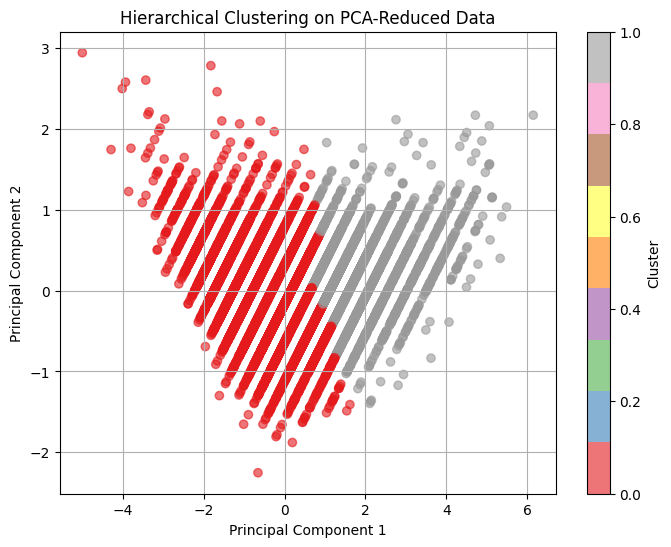

In [22]:


plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='Set1', alpha=0.6)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Hierarchical Clustering on PCA-Reduced Data')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()

             Price    Rating         Year
Cluster                                  
0        15.090605 -0.360583  2016.299916
1        93.085684  1.207575  2013.068846


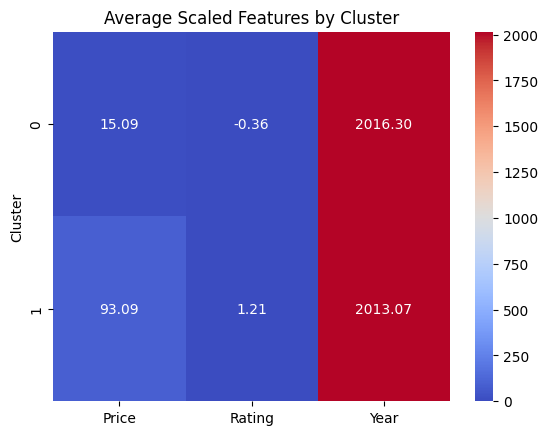

In [23]:



cluster_means = df_wine_scaled.groupby('Cluster')[['Price', 'Rating', 'Year']].mean()
print(cluster_means)
sns.heatmap(cluster_means, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Average Scaled Features by Cluster')
plt.ylabel('Cluster')
plt.show()

Type      red  rose  sparkling  white
Cluster                              
0        6215   384        745   3309
1        2451    13        262    455


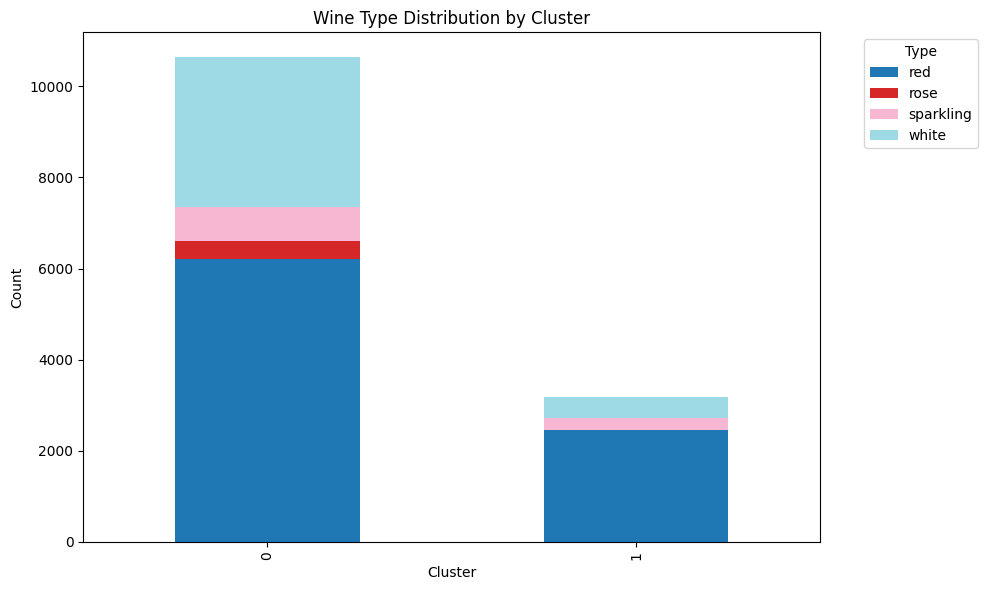

In [24]:


wine_type_counts = df_wine_scaled.groupby(['Cluster', 'Type']).size().unstack(fill_value=0)
print(wine_type_counts)
wine_type_counts.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='tab20')
plt.title('Wine Type Distribution by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.legend(title='Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()



The dendrogram-based clustering separated the wines into two main clusters:

**Cluster 0:**

Lower price (avg ~€15)

Lower rating

More recent vintage (avg year ~2016)

**Cluster 1:**

Higher price (avg ~€93)

Higher rating

Older vintage (avg year ~2013)

This suggests the model effectively distinguished between budget-friendly newer wines and premium, older, higher-rated wines. The features Price, Rating, and Year played strong roles in driving this separation.



**Gaussian Mixture Model (GMM)**

Gaussian Mixture Models offer a flexible, probabilistic approach to clustering, where each data point is assigned a probability of belonging to each cluster rather than a hard label. This is particularly useful for our wine dataset, where boundaries between wine preferences may be soft and overlapping (e.g., price and rating don’t always have clear-cut separations).

**Why GMM suits our project best**

Unlike KMeans, which assumes spherical clusters of equal size, GMM can model elliptical clusters of varying sizes and densities—better capturing the complex relationships among wine features like price, rating, and year.

Compared to Hierarchical Clustering, GMM is more scalable and computationally efficient on larger datasets, making it better suited for interactive or consumer-focused recommendation systems.

GMM provides soft assignments, which is ideal for personalized wine suggestions where wines may belong to multiple taste profiles to some degree.

In [25]:

#GMM: Gaussian Mixture Model
# Use only numeric features
numeric_features = ['Price', 'Rating', 'Year']
X = df_wine[numeric_features].values

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit Gaussian Mixture Model
n_components = 3  
gmm = GaussianMixture(n_components=n_components, random_state=42)
gmm.fit(X_scaled)

# Predict cluster labels
labels = gmm.predict(X_scaled)

# Add cluster labels to original dataframe
df_wine['GMM_Cluster'] = labels

# Inverse transform means for interpretability
cluster_centers = scaler.inverse_transform(gmm.means_)

# Show cluster centers
print("Cluster centers (approximate):")
for i, center in enumerate(cluster_centers):
    print(f"Cluster {i}:")
    for f, val in zip(numeric_features, center):
        print(f"  {f}: {val:.2f}")
    print()

Cluster centers (approximate):
Cluster 0:
  Price: 12.39
  Rating: 3.73
  Year: 2016.93

Cluster 1:
  Price: 40.01
  Rating: 4.02
  Year: 2014.25

Cluster 2:
  Price: 198.20
  Rating: 4.35
  Year: 2009.15





We trained GMMs with different numbers of clusters (e.g., 1 to 10), and for each, calculated AIC and BIC. By plotting AIC and BIC vs. number of clusters, we looked for the point where these metrics reach their lowest values (elbow or minimum point). That point indicates the optimal number of clusters—where the model best fits the data without being overly complex.

From the graph below, I decided we can use cluster_number = 3

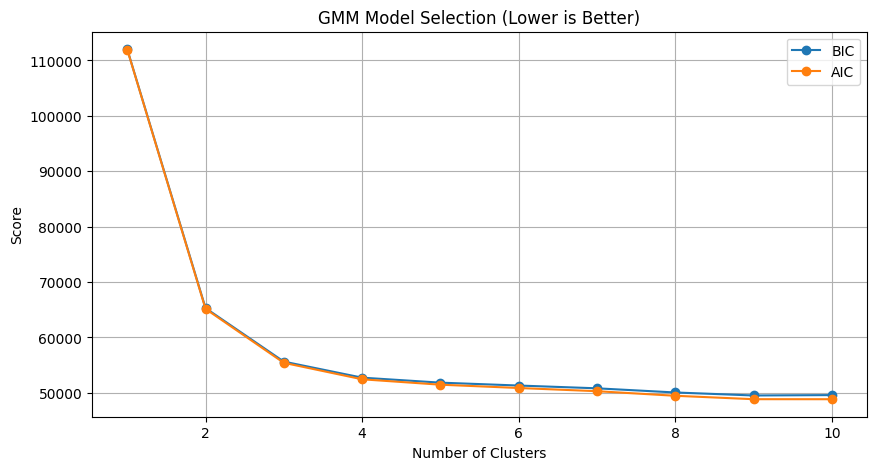

In [26]:



# Range of components to try
n_components_range = range(1, 11)

#BIC (Bayesian Information Criterion) and AIC (Akaike Information Criterion).
bics = []
aics = []

for n in n_components_range:
    gmm = GaussianMixture(n_components=n, random_state=42)
    gmm.fit(X_scaled)
    bics.append(gmm.bic(X_scaled))
    aics.append(gmm.aic(X_scaled))

# Plot BIC and AIC
plt.figure(figsize=(10, 5))
plt.plot(n_components_range, bics, label='BIC', marker='o')
plt.plot(n_components_range, aics, label='AIC', marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('GMM Model Selection (Lower is Better)')
plt.legend()
plt.grid(True)
plt.show()


**Summary of GMM**

**Cluster 0:**
Wines are affordable, with an average price of €12.39, a moderate rating (3.73), and are relatively recent (2016 vintage).

**Cluster 1:**
Wines are in the mid-price range (€40.01), have a higher average rating (4.02), and are from an older vintage (2014).

**Cluster 2:**
Wines are premium-priced (€198.20), have the highest ratings (4.35), and are the oldest on average (2009 vintage).

This clustering suggests that price, rating, and age are positively correlated and can effectively segment wine types for recommendation purposes.


**Application**
Based on our clustering results, we can apply these insights to build a content-based recommender system. When a user inputs the name of a wine they like, we identify its cluster based on features such as price, rating, and vintage. We then recommend other wines within the same cluster, as they share similar characteristics and are likely to match the user’s preferences. This approach personalizes recommendations without needing user history or collaborative data, making it ideal for first-time users or niche wine preferences.

In [27]:


#Content Based recommender system

feature_matrix = df_wine_encoded[all_features]
# 1. Compute pairwise cosine similarity
cos_sim_matrix = cosine_similarity(feature_matrix)


In [39]:


df_wine_encoded = pd.get_dummies(df_wine, columns=['Region'])
feature_cols = ['Year', 'Price', 'Rating'] + [col for col in df_wine_encoded.columns if col.startswith('Region_')]

def recommend_wines_by_gmm(wine_name, top_n=1):
    # Step 1: Find the wine by name
    matches = df_wine_scaled[df_wine_scaled['Name'].str.lower() == wine_name.lower()]
    
    if len(matches) == 0:
        raise ValueError(f"No wine found with name '{wine_name}'")
    elif len(matches) > 1:
        raise ValueError(f"Multiple matches found for '{wine_name}'. Please specify more precisely.")
    
    wine_idx = matches.index[0]

    # Step 2: Extract only the GMM features
    gmm_features = ['Price', 'Rating', 'Year']
    wine_vector = df_wine_scaled.loc[wine_idx, gmm_features].values.astype(float).reshape(1, -1)

    # Step 3: Predict cluster
    wine_cluster = gmm.predict(wine_vector)[0]

    # Step 4: Get wines in same cluster (excluding current wine)
    cluster_indices = gmm.predict(df_wine_scaled[gmm_features])
    cluster_wines = df_wine_scaled[(cluster_indices == wine_cluster) & (df_wine_scaled.index != wine_idx)]

    # Step 5: Compute distances using only GMM features
    all_vectors = cluster_wines[gmm_features].values.astype(float)
    wine_vector = wine_vector.flatten()  # Now shape is (3,)
    distances = np.linalg.norm(all_vectors - wine_vector, axis=1)

    # Step 6: Get top N
    nearest_idx = distances.argsort()[:top_n]
    return df_wine.loc[cluster_wines.iloc[nearest_idx].index]

In [41]:

print(recommend_wines_by_gmm('10 Barricas 2015', top_n=1)
)

                                                  Name Country  \
1423  Ripa della Volta Amarone della Valpolicella 2015   Italy   

                          Region   Winery  Rating  NumberOfRatings  Price  \
1423  Amarone Della Valpolicella  Ottella     4.3              153   37.9   

        Year Type  isNonvintage  GMM_Cluster  
1423  2015.0  red             0            1  


In [43]:


text_input = widgets.Text(
    value='',
    placeholder='Enter wine name here',
    description='Wine Name:',
    layout=widgets.Layout(width='400px')
)

submit_button = widgets.Button(description="Submit")

output = widgets.Output()

def on_submit_button_clicked(b):
    with output:
        clear_output()
        wine_name = text_input.value.strip()
        if not wine_name:
            print("Please enter a wine name.")
            return
        try:
            recs = recommend_wines_by_gmm(wine_name, top_n=5)
            print(f"Recommendations similar to '{wine_name}':")
            display(recs[['Name', 'Region', 'Year', 'Price', 'Rating']])
        except ValueError as e:
            print(str(e))

submit_button.on_click(on_submit_button_clicked)

display(text_input, submit_button, output)


Text(value='', description='Wine Name:', layout=Layout(width='400px'), placeholder='Enter wine name here')

Button(description='Submit', style=ButtonStyle())

Output()